# Exploration Summarize

The problem is to label the cause of a fire by it's size, location and date

In [45]:
import pandas as pd
import sqlite3
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [46]:
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")
fires_tbl = pd.read_pickle(r"C:\Guy\University\third year\Applied Competitive\wildfires\Applied_Lab_Project\fires_tiny.pickle")

In [47]:
display(fires_tbl.head())
fires_tbl.columns

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

# Label distribution in train

We can see that the labels are imbalanced, so:

**#Todo**
1. consider stratification or other methods.      
2. metrics for the models should be recall for every class.


Text(0.5, 1.0, 'Label Coverage in training data')

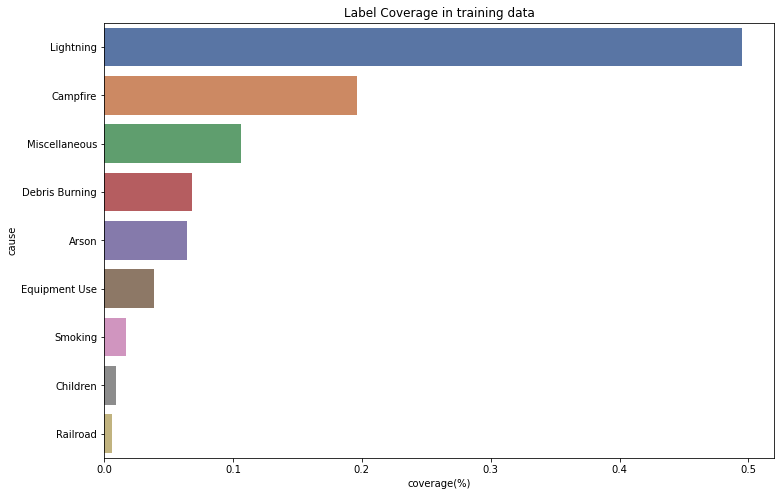

In [48]:
fires_per_cause_perc = fires_tbl.groupby('STAT_CAUSE_DESCR')[['OBJECTID']].count() / fires_tbl.shape[0]
fires_per_cause_perc.sort_values(by='OBJECTID',ascending=False,inplace=True)
fires_per_cause_perc = fires_per_cause_perc.reset_index()
fires_per_cause_perc.columns = ['cause', 'coverage(%)']

plt.figure(figsize=(12,8))
sns.barplot(data = fires_per_cause_perc, x='coverage(%)', y='cause',
            orient='h', palette="deep")
plt.title("Label Coverage in training data")

# Size Features

## Average fire size per class

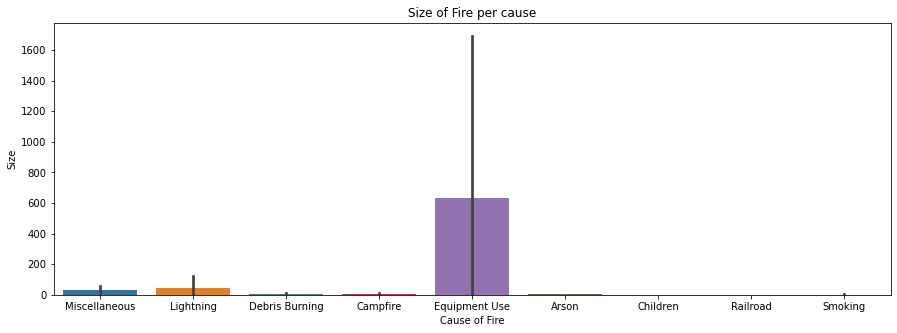

In [49]:
plt.figure(figsize=(15,5))
g = sns.barplot(data = fires_tbl, x = 'STAT_CAUSE_DESCR', y = 'FIRE_SIZE')
plt.xlabel('Cause of Fire')
plt.ylabel('Size')
g.axes.set_title('Size of Fire per cause')
g

### Size distribution

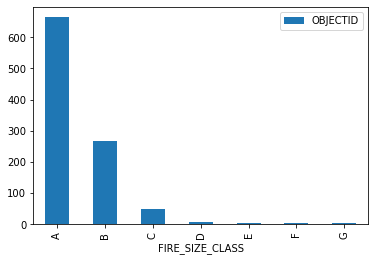

In [50]:
fires_tbl.groupby('FIRE_SIZE_CLASS')[['OBJECTID']].count().plot(kind='bar')

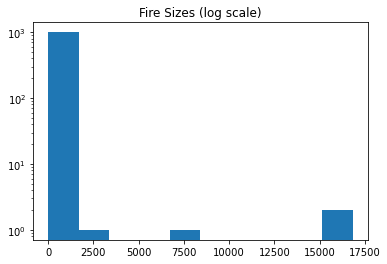

In [51]:
plt.title("Fire Sizes (log scale)")
plt.hist(fires_tbl['FIRE_SIZE'], log=True)
plt.show()

# Time features

## Years Analysis

Years in data span from 1992 to 2015, and on average there were ~78k fires a year

In [52]:
# FIRE_YEAR = Calendar year in which the fire was discovered or confirmed to exist.
print("First year in DB is: " + str(fires_tbl.FIRE_YEAR.min()))
print("Last year in DB is: " + str(fires_tbl.FIRE_YEAR.max()))
fires_per_year = fires_tbl.groupby('FIRE_YEAR').count()['OBJECTID']
print(fires_per_year)
print("This is a summary of the fires per year: ")
print(fires_per_year.describe())

First year in DB is: 2004
Last year in DB is: 2005
FIRE_YEAR
2004     32
2005    968
Name: OBJECTID, dtype: int64
This is a summary of the fires per year: 
count      2.000000
mean     500.000000
std      661.851947
min       32.000000
25%      266.000000
50%      500.000000
75%      734.000000
max      968.000000
Name: OBJECTID, dtype: float64


## Date Analysis

DISCOVERY_DATE = Date on which the fire was discovered or confirmed to exist.
CONT_DATE = Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year)

In [53]:
fires_tbl['DISCOVERY_DATE'] = pd.to_datetime(fires_tbl['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fires_tbl['CONT_DATE'] = pd.to_datetime(fires_tbl['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [54]:
print(fires_tbl['DISCOVERY_DATE'].describe())
print(fires_tbl['CONT_DATE'].describe())

count                    1000
unique                    187
top       2005-07-16 00:00:00
freq                       29
first     2004-03-18 00:00:00
last      2005-08-19 00:00:00
Name: DISCOVERY_DATE, dtype: object
count                     999
unique                    193
top       2005-07-22 00:00:00
freq                       26
first     2004-03-18 00:00:00
last      2005-08-22 00:00:00
Name: CONT_DATE, dtype: object


### Creating a month feature

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 12.,  19.,  36.,  83., 114., 209., 363., 154.,   2.,   7.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

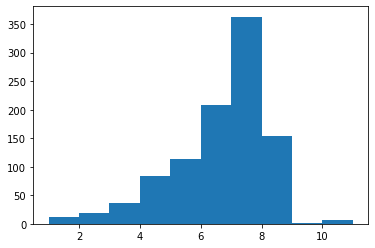

In [55]:
months_of_fires = fires_tbl['CONT_DATE'].apply(lambda x: x.month)
fires_tbl['month_of_fire'] = months_of_fires
plt.hist(fires_tbl['month_of_fire'])

### Connection between month and cause of fire (proportion distribution)
We can see that some causes occur mostly on specific months (e.g fireworks and lightning)

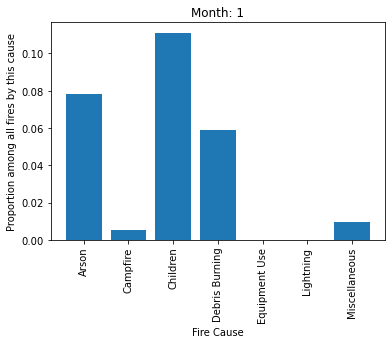

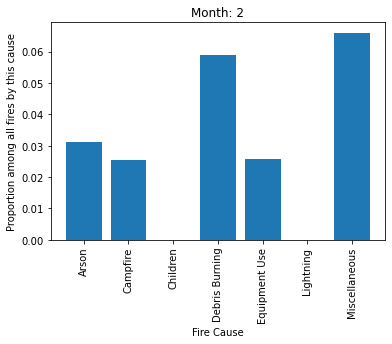

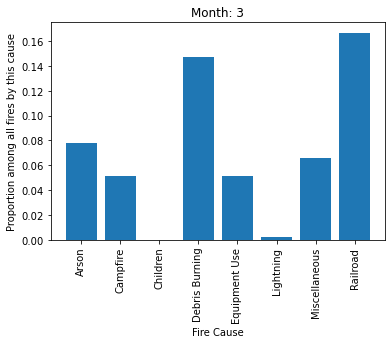

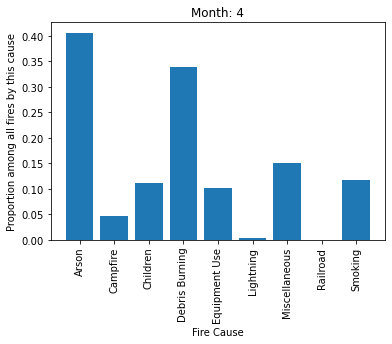

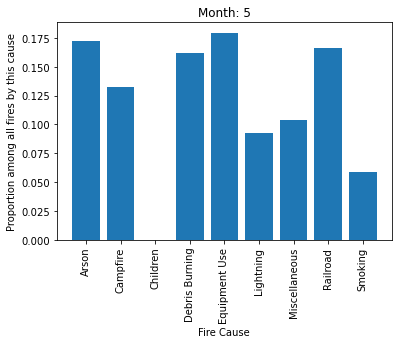

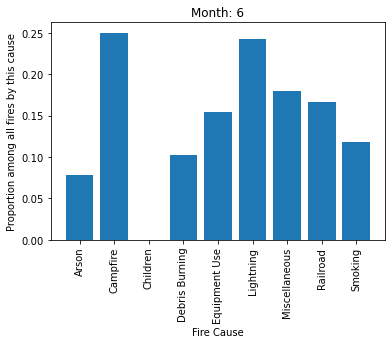

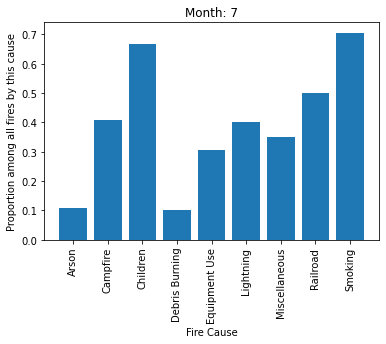

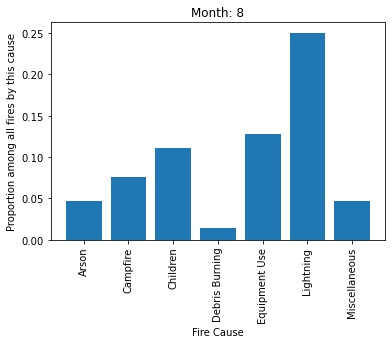

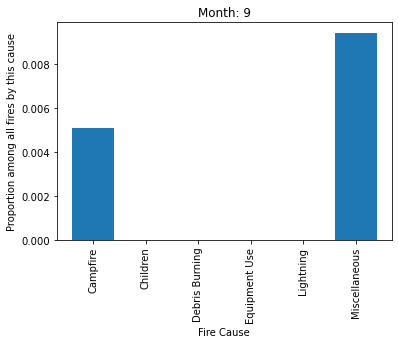

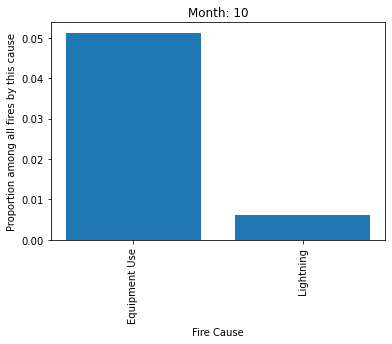

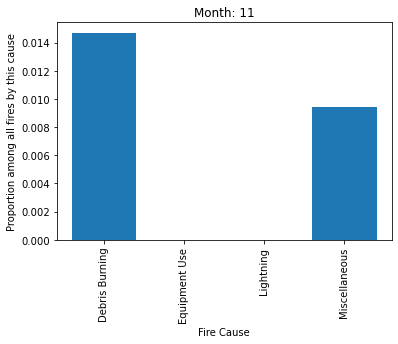

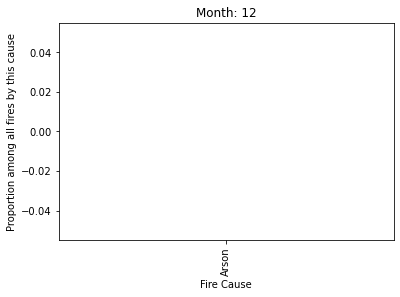

In [56]:
total_df_by_causes = fires_tbl.groupby('STAT_CAUSE_DESCR').count()
for month in range(1, 13):
    df_of_month_by_causes = fires_tbl[fires_tbl['month_of_fire'] == month]\
        .groupby('STAT_CAUSE_DESCR').count()
    df_of_proportion_in_month_per_cause = (df_of_month_by_causes /
                                           total_df_by_causes).reset_index()
    plt.bar(df_of_proportion_in_month_per_cause['STAT_CAUSE_DESCR'],
            df_of_proportion_in_month_per_cause['OBJECTID'])
    plt.title("Month: " + str(month))
    plt.xticks(rotation='vertical')
    plt.xlabel('Fire Cause')
    plt.ylabel('Proportion among all fires by this cause')
    plt.show()

### Analysis of lightning

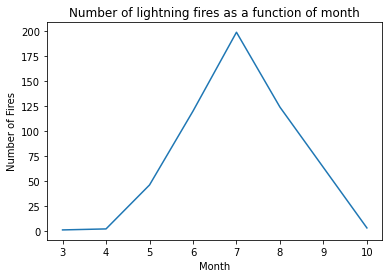

In [57]:
df_of_lightning = fires_tbl[fires_tbl['STAT_CAUSE_DESCR'] == 'Lightning']
lightning_per_month = df_of_lightning.groupby('month_of_fire').count().reset_index()
plt.plot(lightning_per_month['month_of_fire'], lightning_per_month['OBJECTID'])
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.title('Number of lightning fires as a function of month')
plt.show()

### Analysis of Fireworks

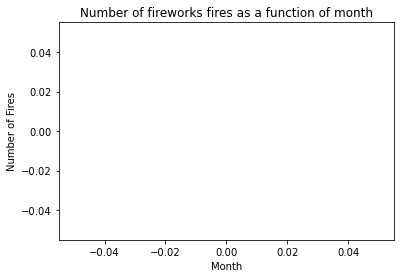

In [58]:
df_of_lightning = fires_tbl[fires_tbl['STAT_CAUSE_DESCR'] == 'Fireworks']
lightning_per_month = df_of_lightning.groupby('month_of_fire').count().reset_index()
plt.plot(lightning_per_month['month_of_fire'], lightning_per_month['OBJECTID'])
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.title('Number of fireworks fires as a function of month')
plt.show()

# Connection between month and state (proportion distribution)
We can see that some states had a lot of their fires (more than 30%) in a specific month

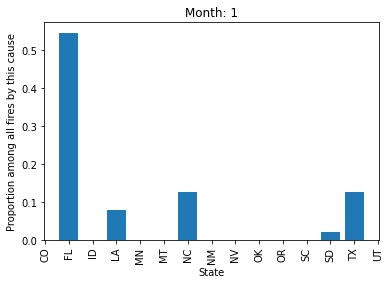

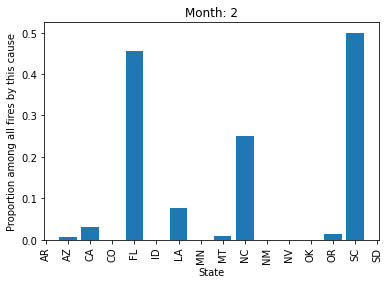

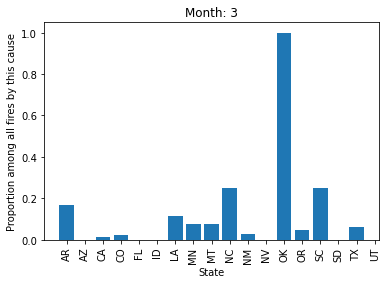

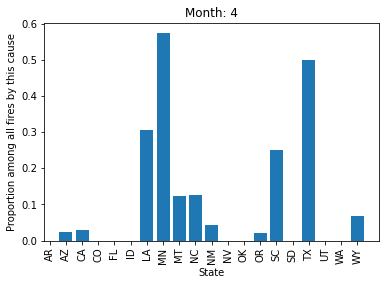

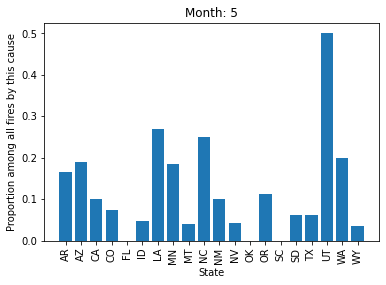

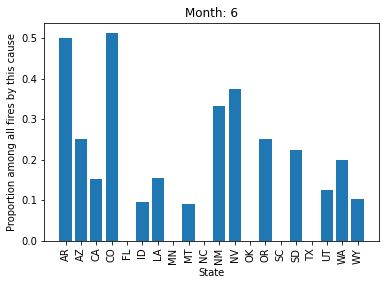

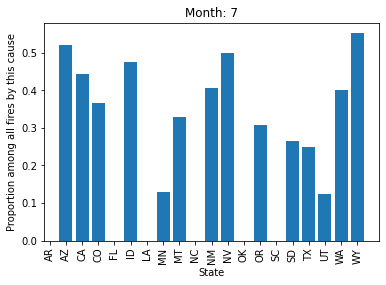

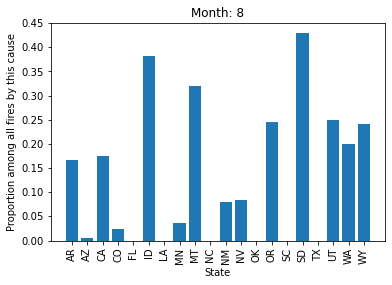

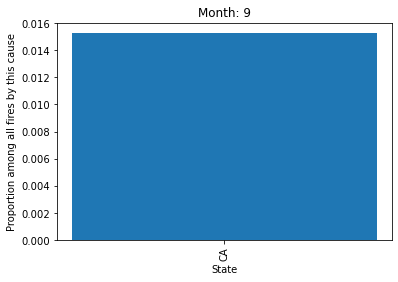

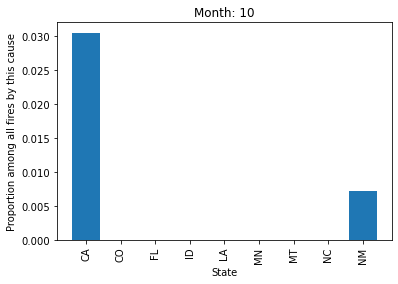

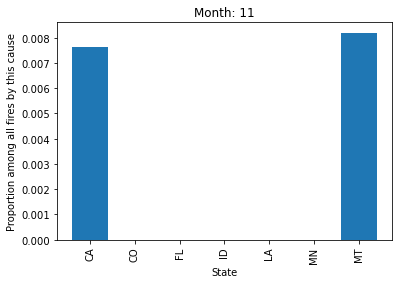

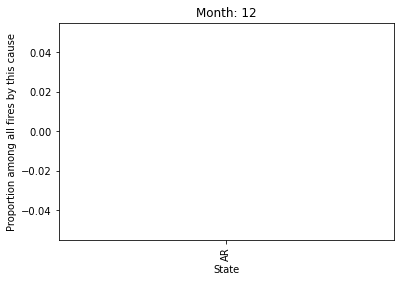

In [59]:
total_df_by_states = fires_tbl.groupby('STATE').count()
for month in range(1, 13):
    df_of_month_by_states = fires_tbl[fires_tbl['month_of_fire'] == month]\
        .groupby('STATE').count()
    df_of_proportion_in_month_per_state = (df_of_month_by_states /
                                           total_df_by_states).reset_index()
    plt.bar(df_of_proportion_in_month_per_state['STATE'],
            df_of_proportion_in_month_per_state['OBJECTID'])
    plt.title("Month: " + str(month))
    plt.xticks(rotation='vertical')
    plt.xlabel('State')
    plt.ylabel('Proportion among all fires by this cause')
    plt.show()

### Creating a new Feature - Time to control fire (in days)

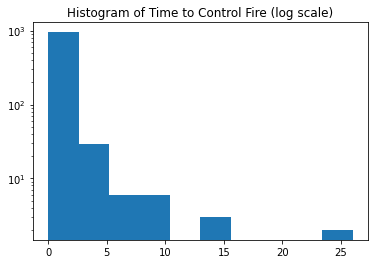

In [60]:
days_to_control_fire = fires_tbl.CONT_DOY - fires_tbl.DISCOVERY_DOY
days_to_control_fire = days_to_control_fire.dropna()
days_to_control_fire = abs(days_to_control_fire % 366)

plt.title("Histogram of Time to Control Fire (log scale)")
plt.hist(days_to_control_fire, log=True)
plt.show()

Most fires (~80%) were controlled on the same day

In [61]:
print("Proportion of fires which took less than a day to control: " +
      str(np.count_nonzero((days_to_control_fire == 0)) /
          (len(days_to_control_fire) - days_to_control_fire.isna().sum())))

print(days_to_control_fire.describe())

Proportion of fires which took less than a day to control: 0.6986986986986987
count    999.000000
mean       0.589590
std        1.728499
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       26.000000
dtype: float64


### connection between days to control fire and size of fire

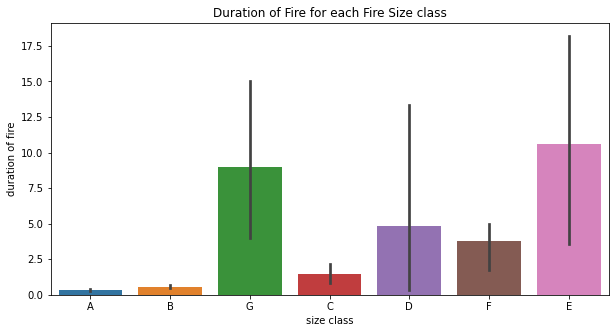

In [62]:
fires_tbl["fire_duration"]= days_to_control_fire
plt.figure(figsize=(10,5))
g = sns.barplot(data = fires_tbl, y = 'fire_duration', x = 'FIRE_SIZE_CLASS')
plt.xlabel('size class')
plt.ylabel('duration of fire')
g.axes.set_title('Duration of Fire for each Fire Size class')
g

In [63]:
fires_tbl.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'month_of_fire', 'fire_duration'],
      dtype='object')

In [64]:
fires_tbl[['OBJECTID', 'FIRE_YEAR', 'month_of_fire', 'fire_duration', 'FIRE_SIZE', 'STATE', 'COUNTY' ,'STAT_CAUSE_DESCR']].to_pickle("Wildfires.pkl")

### A lot of NA's in contained day column (~40%)
we need to fill them later somehow

In [65]:
print("Number of na's in contained day is: " + str(fires_tbl.CONT_DOY.isna().sum()))

Number of na's in contained day is: 1


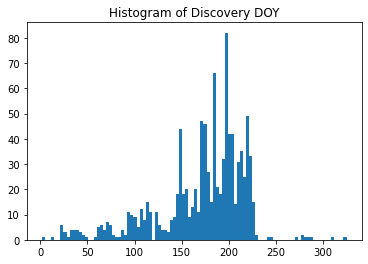

In [66]:
plt.title("Histogram of Discovery DOY")
plt.hist(fires_tbl.DISCOVERY_DOY, bins=100)
plt.show()

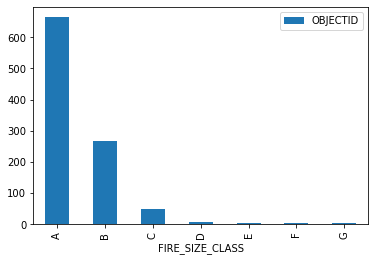

In [67]:
fires_tbl.groupby('FIRE_SIZE_CLASS')[['OBJECTID']].count().plot.bar()

Text(0.5, 1.0, 'NULL distribution over size class')

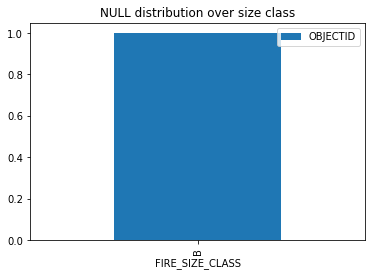

In [68]:
fires_tbl[fires_tbl['CONT_DOY'].isna()].groupby('FIRE_SIZE_CLASS')[['OBJECTID']].count().plot.bar()
plt.title("NULL distribution over size class")

In [69]:
import missingno as msn

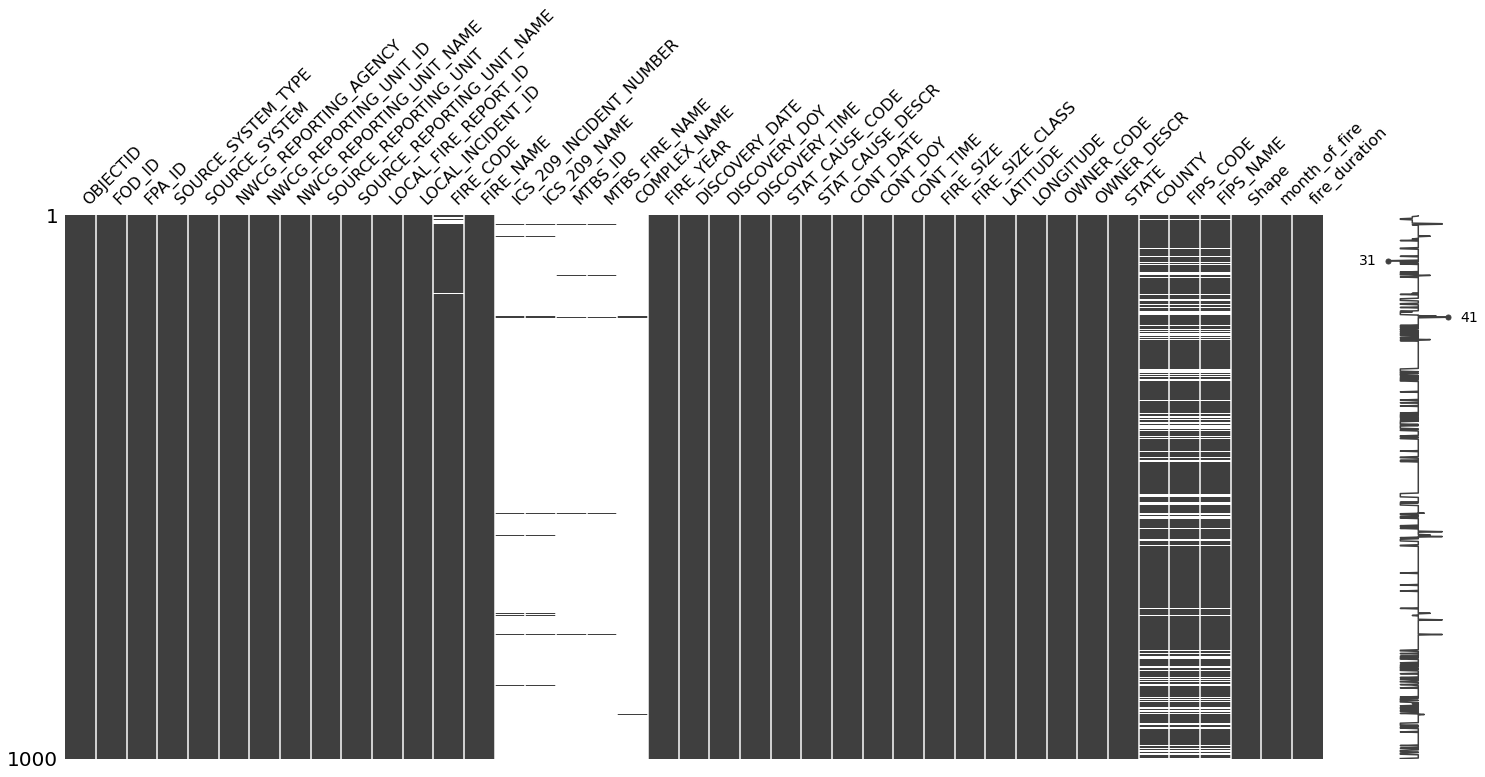

In [70]:
msn.matrix(fires_tbl)

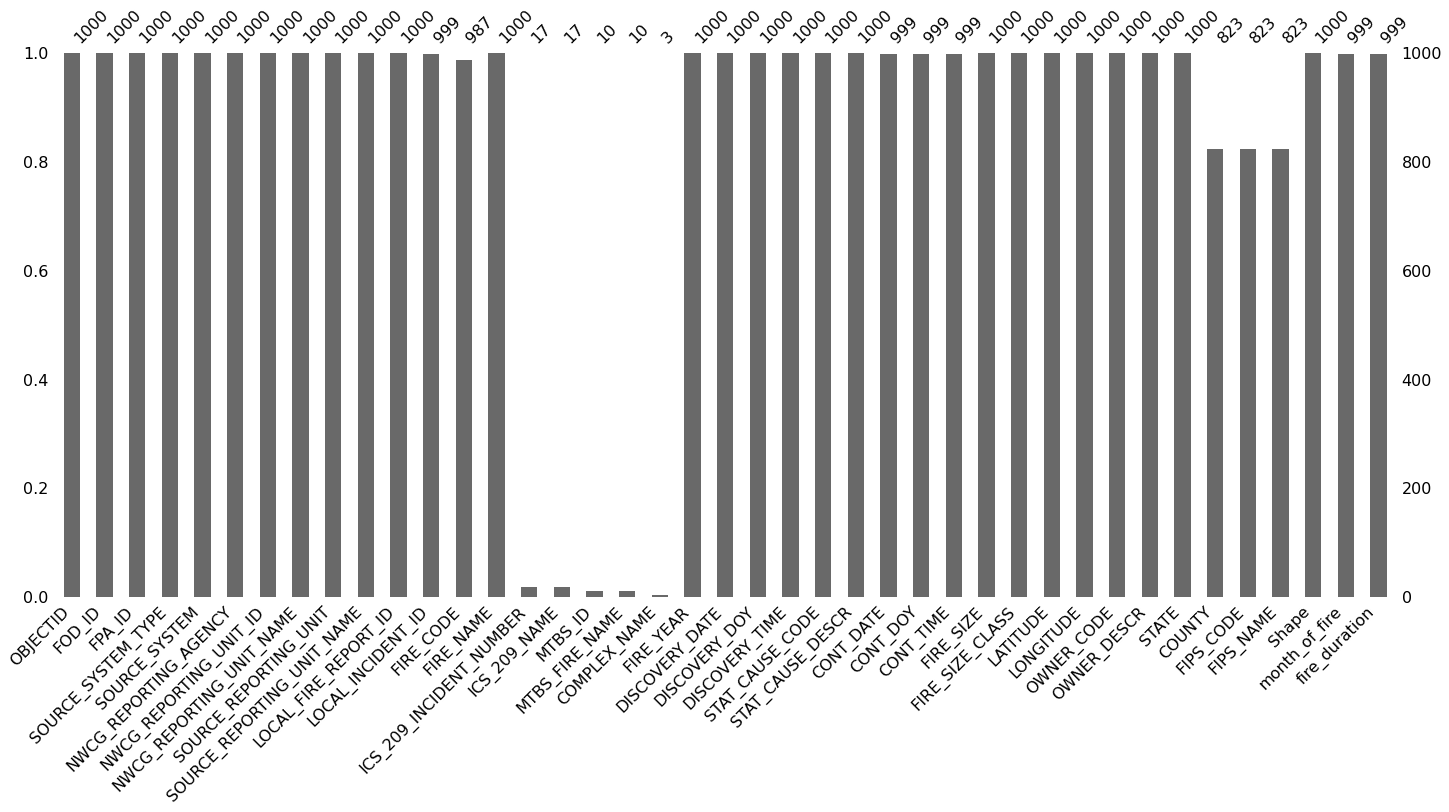

In [71]:
msn.bar(fires_tbl)

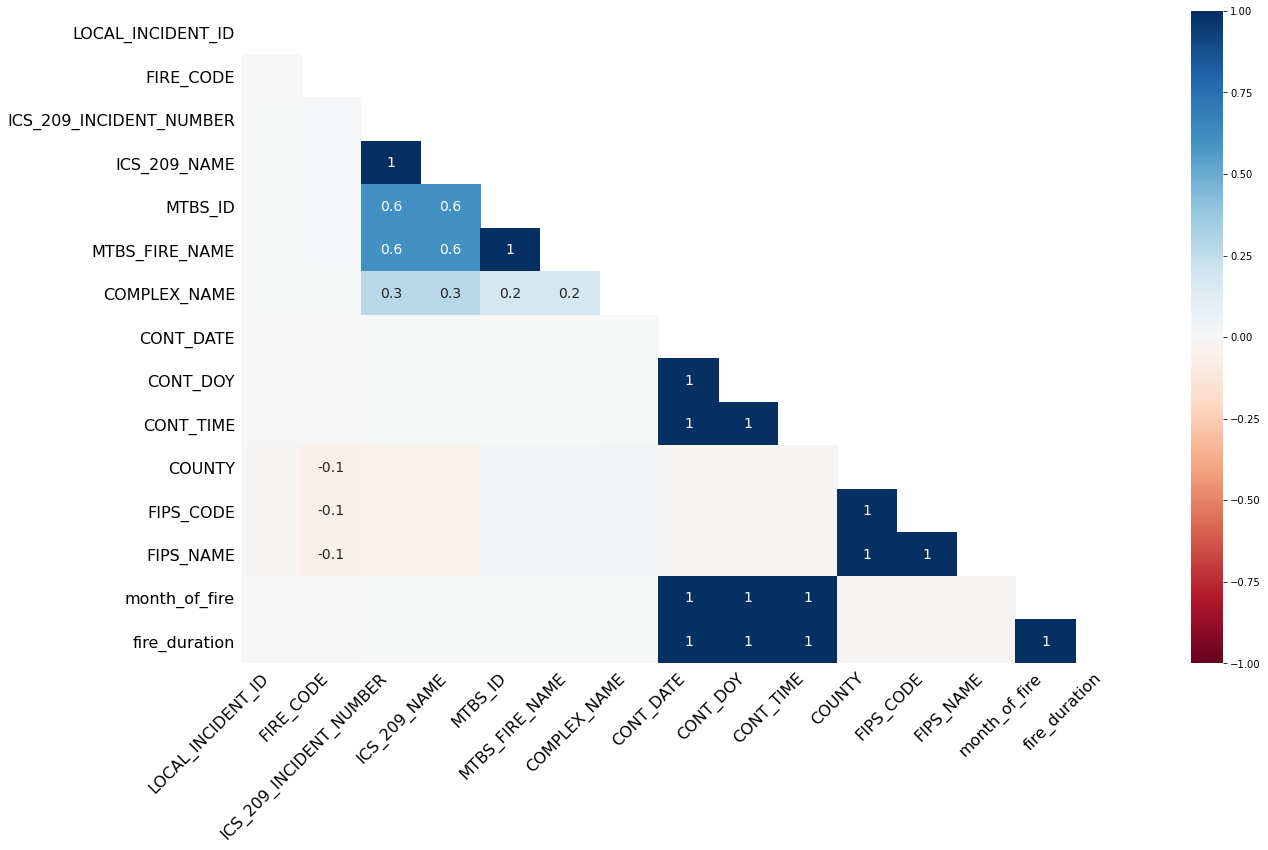

In [72]:
msn.heatmap(fires_tbl)

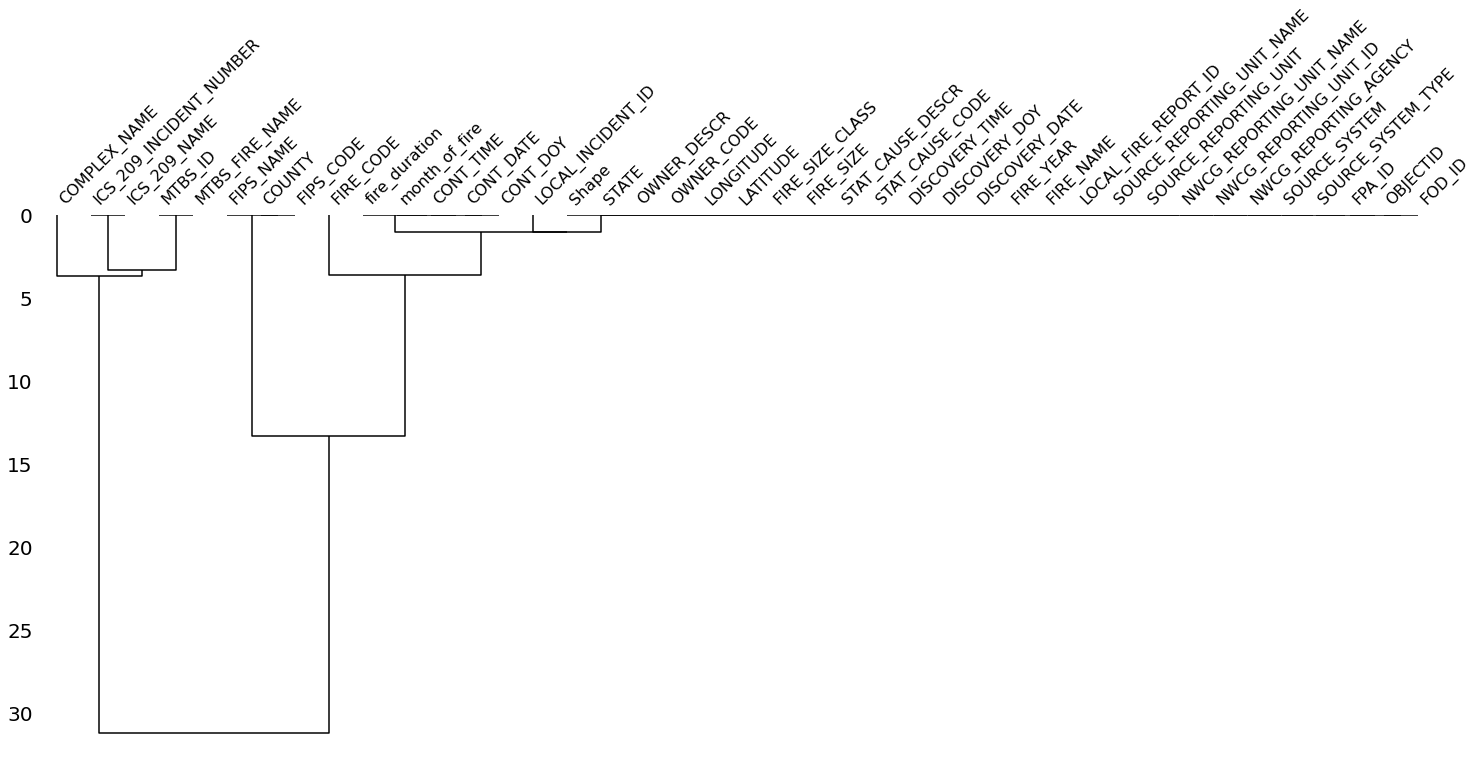

In [73]:
msn.dendrogram(fires_tbl)

Text(0.5, 1.0, 'Time to control fire, not null by size (for imputation)')

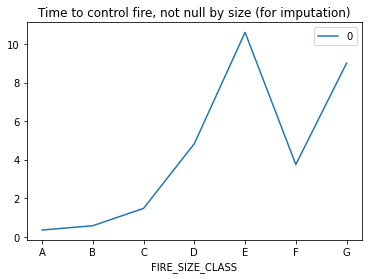

In [74]:
handling_na = fires_tbl[['DISCOVERY_DATE','CONT_DATE','FIRE_SIZE_CLASS']].set_index('FIRE_SIZE_CLASS')

modeling_time_till_containment = (handling_na.CONT_DATE - handling_na.DISCOVERY_DATE).dt.days.reset_index().dropna().groupby('FIRE_SIZE_CLASS').mean()
modeling_time_till_containment.plot()
plt.title("Time to control fire, not null by size (for imputation)")

In [75]:
diff = (handling_na.CONT_DATE - handling_na.DISCOVERY_DATE).dt.days
handling_na['diff'] = diff.groupby("FIRE_SIZE_CLASS").transform(lambda x: x.fillna(x.mean()))

In [76]:
fires_tbl['days_to_control'] = fires_tbl.CONT_DATE - fires_tbl.DISCOVERY_DATE
fires_tbl['days_to_control'] = fires_tbl.groupby("FIRE_SIZE_CLASS").transform(lambda x: x.fillna(x.mean()))

In [77]:
fires_tbl['days_to_control']

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: days_to_control, Length: 1000, dtype: object

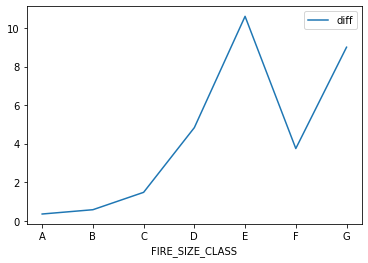

In [78]:
handling_na.reset_index().groupby('FIRE_SIZE_CLASS')[['diff']].mean().plot()

In [79]:
month = fires_tbl['DISCOVERY_DATE'].apply(lambda x: x.month)
pd.get_dummies(month)


,1,2,3,4,5,6,7,8,9,10,11
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,1,0,0,0
996,0,0,1,0,0,0,0,0,0,0,0
997,0,0,0,1,0,0,0,0,0,0,0
998,0,0,0,1,0,0,0,0,0,0,0


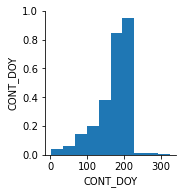

In [80]:
sns.pairplot(data=fires_tbl[['CONT_DOY','FIRE_SIZE_CLASS']].dropna())

# Location features

In [81]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
county_geo = f'{url}/us-county.json'

pop_size_state = pd.read_csv('size_pop_states.csv')
abbreviations = pd.read_csv('states_code.csv')[['State','Code']]
pop_size_data = pd.merge(pop_size_state, abbreviations, left_on='State', right_on='State')
pop_size_data = pop_size_data.drop('State', axis=1)
pop_size_data = pop_size_data.rename(columns={'Code':'STATE'})

In [82]:
def get_base_map():
    return folium.Map(location=[48, -102], zoom_start=3.2)

def show_map_by_states(df, label):
    """this function assumes that the data frame first column is the state abbreviations, 
    and the second column is the data to be plotted."""
    map = get_base_map()
    
    map.choropleth(geo_data=state_geo, data=df,
                 columns=df.columns,
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name=label)
    return map
    
def show_point_map():
    map = get_base_map()

## fire count by country

In [83]:
count_per_country = fires_tbl.groupby('STATE')[['OBJECTID']].count().reset_index()

In [89]:
show_map_by_states(count_per_country, "Number of Fires")

## Normalize fires between states

we use two measures in order to compare states: number of fires by land size in state, and by population size

### Land size - comparable view

In [86]:
land_df = pd.merge(count_per_country, pop_size_data[['STATE', 'LandArea']], on='STATE')
land_df['fires_per_sqm'] = land_df['OBJECTID'] / land_df['LandArea']
fires_per_sqm = land_df[['STATE','fires_per_sqm']]
show_map_by_states(fires_per_sqm, "Fires per square mile")

### Population size - comparable view

In [88]:
pop_df = pd.merge(count_per_country, pop_size_data[['STATE', 'Pop']], on='STATE')
pop_df['fires_per_pop'] = pop_df['OBJECTID'] / pop_df['Pop']
fires_per_pop = pop_df[['STATE','fires_per_pop']]
show_map_by_states(fires_per_pop, "Fires per Population Size")

## Distribution of every state by years (mean,std)
Is the data reliable in the state level?

## Distribution of every state by months (mean,std)

P(Label|STATE)

P(Label|STATE, MONTH)

P(Label|ownership)

P(Label|STATE) compare normalized by popsize

P(SIZE|STATE)

### label per country

In [ ]:
states = fires_tbl['STATE'].unique()
countries_causes = pd.DataFrame()
for state in states:
    countries_causes[state]=fires_tbl[fires_tbl['STATE']==state].groupby('STAT_CAUSE_DESCR')[['OBJECTID']].count()['OBJECTID']
countries_causes = countries_causes.fillna(0)
countries_causes = countries_causes.div(countries_causes.sum(axis=0))
countries_causes

In [ ]:
top_contries = fires_tbl.groupby("STATE")[['OBJECTID']].count().sort_values(by='OBJECTID', ascending=False)
for i in range(2,5):
    countries_causes[top_contries.index[i]].plot(kind='bar', title="Label distribution - fire causes in "+top_contries.index[i])
    plt.show()

### connection between country and size of fire

In [ ]:
fires_tbl['log_size'] = np.log(fires_tbl['FIRE_SIZE'])
fire_size = fires_tbl.groupby('STATE')[['log_size']].mean().reset_index()
show_geopolitical_map(fire_size, "Size of Fires (log scale)")